# Cat Vs Dog

## Imports 

In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

## Variables

In [2]:
# Download dataset from
# https://www.kaggle.com/c/dogs-vs-cats/data

In [37]:
IMG_SIZE = 224
DIR = r"D:\Data Science\DataSets\Cat vs Dog\train"
CATEGORIES = ['Cat','Dog']

## Reading Images

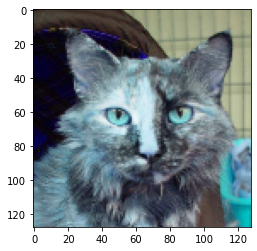

In [6]:
path = os.path.join(r'D:\Data Science\Machine Learning\Dog vs Cat\data',CATEGORIES[0])
imgpath = os.path.join(path,os.listdir(path)[2])
imgarr = cv2.imread(imgpath)
imgarr = cv2.resize(imgarr,(IMG_SIZE,IMG_SIZE))
plt.imshow(imgarr)

## For Model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization

##   Optimize Using Keras Tuner

In [17]:
def hp_model(hp):
    model = keras.Sequential([
            keras.layers.Conv2D(
                filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                activation='relu',
                input_shape=(IMG_SIZE,IMG_SIZE,3)
            ),
            keras.layers.MaxPooling2D(pool_size=hp.Choice('pool1', values = [3,5])),

 
            keras.layers.Conv2D(
                filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                activation='relu'
            ),
            keras.layers.MaxPooling2D(pool_size=hp.Choice('pool2', values = [3,5])),

            keras.layers.Flatten(),
            keras.layers.Dense(
                units=hp.Int('dense_1_units', min_value=64, max_value=512, step=16),
                activation='relu'
            ),
            keras.layers.Dropout(0.4),

            keras.layers.Dense(
                units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                activation='relu'
            ),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(2, activation='softmax')
          ])

    model.compile(optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

## Using Random Search

In [18]:
from kerastuner import RandomSearch

tuner = RandomSearch(hp_model,objective='val_accuracy',max_trials=5,directory='Output',project_name='Dog vs Cat',)


C:\Users\murth\AppData\Local\Temp/ipykernel_6516/406843279.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [19]:
# from sklearn.model_selection import train_test_split

# X_tain,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42)


In [20]:
tuner.search(X,y,epochs=5,validation_split=0.1)

Trial 5 Complete [00h 00m 35s]
val_accuracy: 0.5299999713897705

Best val_accuracy So Far: 0.7866666913032532
Total elapsed time: 00h 03m 15s
INFO:tensorflow:Oracle triggered exit


## Model Accuracy

In [10]:
def plo_acc_loss(history,mode):
    plt.plot(history.history[mode])
    plt.plot(history.history[f'val_{mode}'])
    plt.title(f'model {mode}')
    plt.ylabel(mode)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
# plo_acc_loss(history,'accuracy')

## Model Loss

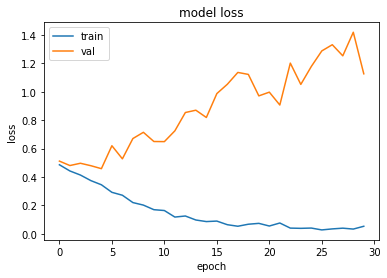

In [27]:
plo_acc_loss(history,'loss')

# Using Transfer learning

In [38]:
from tensorflow.keras.applications import DenseNet121

In [65]:
dens = DenseNet121(include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3),weights= "imagenet",pooling='avg')

In [66]:
dens.trainable = False
# for layer in dens.layers:
#     print(layer.name)

In [67]:
def model_build(model):
    m = Sequential()
    m.add(model)
    m.add(Dense(128,activation='relu'))
    m.add(Dropout(0.3))
    m.add(Dense(1,activation='sigmoid'))
    
    m.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])
    
    m.summary()
    
    return m
    

In [68]:
cnn = model_build(dens)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_20 (Dense)            (None, 128)               131200    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,168,833
Trainable params: 131,329
Non-trainable params: 7,037,504
_________________________________________________________________


## Our model tends to overfit
### So we are going to use data generation from keras

In [69]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    validation_split= 0.05,
    zoom_range=0.2)


train_gen = train_data.flow_from_directory(
    'data/train',
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=32,
    class_mode='binary',
)

val_data = ImageDataGenerator(rescale=1./255)

val_gen = val_data.flow_from_directory('data/train',
                                       target_size=(IMG_SIZE,IMG_SIZE),
                                       batch_size=32,
                                       class_mode='binary')


Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


### Fiting the dgenerated data to our model

In [71]:
img_generator_model =  cnn.fit(
    train_gen,
    steps_per_epoch=train_gen.samples//32,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_gen.samples//32)

Epoch 1/10
187/187 [==============================] - 232s 1s/step - loss: 0.1010 - accuracy: 0.9651 - val_loss: 0.0550 - val_accuracy: 0.9808
Epoch 2/10
187/187 [==============================] - 145s 777ms/step - loss: 0.0773 - accuracy: 0.9682 - val_loss: 0.0526 - val_accuracy: 0.9804
Epoch 3/10
187/187 [==============================] - 146s 782ms/step - loss: 0.0694 - accuracy: 0.9730 - val_loss: 0.0406 - val_accuracy: 0.9836
Epoch 4/10
187/187 [==============================] - 146s 783ms/step - loss: 0.0611 - accuracy: 0.9764 - val_loss: 0.0373 - val_accuracy: 0.9853
Epoch 5/10
187/187 [==============================] - 145s 777ms/step - loss: 0.0604 - accuracy: 0.9754 - val_loss: 0.0368 - val_accuracy: 0.9851
Epoch 6/10
187/187 [==============================] - 143s 764ms/step - loss: 0.0536 - accuracy: 0.9787 - val_loss: 0.0365 - val_accuracy: 0.9845
Epoch 7/10
187/187 [==============================] - 148s 791ms/step - loss: 0.0492 - accuracy: 0.9794 - val_loss: 0.0318 - va

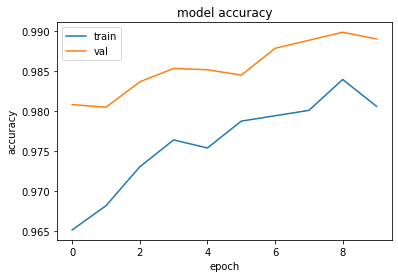

In [72]:
plo_acc_loss(img_generator_model,'accuracy')

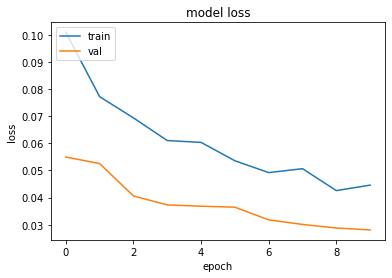

In [73]:
plo_acc_loss(img_generator_model,'loss')


## Saving the Model

In [74]:
cnn.save('dens98.h5')

In [85]:
cnn.evaluate(val_gen)

188/188 [==============================] - 100s 534ms/step - loss: 0.0280 - accuracy: 0.9890


[0.028004193678498268, 0.9890000224113464]

## Load Saved model

In [75]:
loaded = keras.models.load_model('dens98.h5')

## Making some predection

In [76]:
pred = r"D:\Data Science\Machine Learning\Dog vs Cat\data\pred"

predData = []

for files in os.listdir(pred):
        imgpath = os.path.join(pred,files)
        imgarr = cv2.imread(imgpath)
        imgarr = cv2.resize(imgarr,(IMG_SIZE,IMG_SIZE))
        # imgarr = imgarr / 255
        predData.append(imgarr)


In [77]:
len(predData)

10

In [78]:
predData[0].shape

(224, 224, 3)

In [79]:
def show_and_predect(img):
    plt.imshow(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    predection = loaded.predict(img)
    output = np.argmax(predection)
    print("----- Dog -----") if output == 1 else print("----- Cat -----")


----- Cat -----


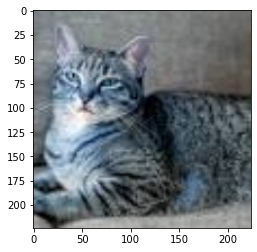

In [101]:
show_and_predect(predData[1])

### Reducing the model size with tflite

In [88]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\murth\AppData\Local\Temp\tmpghk3e7xa\assets


In [89]:
len(tflite_model)

28427640

In [90]:
file  = open('tl_tf.tflite','wb')
file.write(tflite_model)
file.close()

### Reducing with Quantization 

In [91]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\murth\AppData\Local\Temp\tmpeng5uhtj\assets


INFO:tensorflow:Assets written to: C:\Users\murth\AppData\Local\Temp\tmpeng5uhtj\assets


In [92]:
len(tflite_optimized_model)

7639680

In [93]:
file  = open('Q_transferlr.tflite','wb')
file.write(tflite_optimized_model)
file.close()